<a href="https://colab.research.google.com/github/Aari-Rane-Research/AutoRegressiveModeling/blob/main/AariMiniProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Forecasting Using Autoregressive Models #

In this mini-project, we will use Numpy and previous stock data to forecast the return on a stock.

Suppose $P_t$ is the price of a stock at time $t$. We define the return at time $t$ as the relative change in price of a stock at time $t$:

$$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}}.$$

In many statistical models of stocks, we use the log-returns, defined to be

$$X_t = \log(1+R_t)= \log\left(\frac{P_t}{P_{t-1}}\right).$$

(Here $\log$ is the natural log.)

This is because the log-returns have nice statistical properties if we assume some properties for the price of a stock. Furthermore, the log-returns give a good approximation on the raw return $R_t$ if it is small, since for small $x$, $\log(1+x)\approx x$.

We will use the a basic forecasting model, called an *autoregressive model*, to model the returns of some stocks.#

In [2]:
import numpy as np
from typing import Tuple

## Model Construction ##

We will first construct our model, which is known as $\operatorname{AR}(1)$. Here the $1$ refers to the fact that our model will use the information from one time-step prior. Specifically, we will model

$$ X_t-\mu = \phi\cdot(X_{t-1}-\mu)+ɛ_t$$
where $\mu$ is the mean of the $X_t$'s, and $\varepsilon_t$ is a normally distributed random variable with mean $0$ and standard deviation $σ_{ɛ}$.

### Get Log-Returns ###

Complete the function `log_returns` that takes in a Numpy array of closing prices `closing_prices` and returns the Numpy array of the log-returns. Recall that the log-return at time $t$ is computed by

$$X_t = \log\left(\frac{P_t}{P_{t-1}}\right).$$

In case some returns are close to $0$, add $10^{-32}$ to the input of $\log$ so there is no numerical issues with taking $\log(0)$.

In [3]:
def log_returns(closing_prices: np.ndarray) -> np.ndarray:
  logclosing_prices=np.log(closing_prices)
  log_returns=np.diff(logclosing_prices,1)
  return log_returns
closing_prices=[1,2,3,4,5]
log_returns(closing_prices)

array([0.69314718, 0.40546511, 0.28768207, 0.22314355])

### Find the Mean ###

Our first task is to find the mean log-return $\mu$. To do that, we use the estimator

$$\hat{\mu} = \frac{1}{n}\sum_{t=1}^n X_t.$$

This estimator is called the *maximum likelihood estimator*, as it is the choice for $\mu$ that maximizes the likelihood of seeing these values of $X_t$.

Complete the function `estimate_mean`, which returns the estimator for the mean.

In [4]:
def estimate_mean(log_returns: np.ndarray) -> np.ndarray:
  estimate_mean=np.mean(log_returns)
  return estimate_mean


To make our model simpler to work with, we will center the data by computing $Y_t = X_t-\mu$ for all $t$. This ensures our model has mean $0$. Then our model becomes

$$Y_t = \phi Y_{t-1}+ɛ_t.$$

Complete the function `center_data`, which, given the log-return array `log_returns` and the mean `mu`, computes the array of $Y_t$.

In [5]:
def center_data(log_returns: np.ndarray, mu: float) -> np.ndarray:
 centered_data=log_returns-mu
 return centered_data



### Estimating $\phi$ ###

We are now ready to solve for $\phi$. The following is *optional* but is informative.

Since $ɛ_t$ has mean 0, we can try to find an approximate solution to the system

\begin{align}
Y_2 &\approx \phi Y_1 \\
Y_3 &\approx \phi Y_2 \\
&\vdots \\
Y_n &\approx \phi Y_{n-1}
\end{align}

or
$$
\begin{bmatrix}
Y_2 \\
Y_3 \\
\vdots \\
Y_n
\end{bmatrix} \approx \phi \begin{bmatrix}
Y_1 \\
Y_2 \\
\vdots \\
Y_{n-1}
\end{bmatrix}
$$

To find the approximate value of $\phi$, we can use `np.linalg.lstsq`, which finds the *least squares* approximation to $\phi$. To do so, given $Y_1, \ldots, Y_n$, do the following steps:

1. Find the coefficient matrix (of shape `(n-1, 1)`, you may want to use `np.reshape` or `np.newaxis`)

$$ a = \begin{bmatrix}
Y_2 \\
Y_3 \\
\vdots \\
Y_n
\end{bmatrix} $$

2. Find the output matrix (again of shape `(n-1, 1)`)
$$
b = \begin{bmatrix}
Y_1 \\
Y_2 \\
\vdots \\
Y_{n-1}
\end{bmatrix}
$$
3. Use `np.linalg.lstsq` on `a` and `b`. Unfortunately, there are some caveats to the output of this function because it will return a tuple of values. The value of $\phi$ wll be stored in a `(1, 1)` numpy array as the first element of this tuple. However, we need a float in order to make the model work. To extract a float from a `(1, 1)` array (or any numpy array with only 1 element), we can use the method `.item()`. For example, if `arr = [1.0]`, then `arr.item() = 1.0`.

In [6]:
def estimate_phi(centered_data: np.ndarray) -> float:
  a=centered_data[1:,np.newaxis]
  b=centered_data[:len(centered_data)-1,np.newaxis]
  return np.linalg.lstsq(a, b)[0].item()


  """
  Given the centered log-returns, estimate the value of phi in the model.

  INPUT:
  centered_data (np.ndarray): A shape (n,) numpy array that gives the centered log-returns of the stock.

  OUTPUT:
  phi (float): A float that gives the coefficient of the AR model.
  """
  pass

### Estimating $\sigma_{ɛ}^2$ ###

We will now try to estimate the variance of the noise that is added. This can give us a measure of how stable (or unstable) the returns are on our stock.

To do so, note that $ɛ_t = Y_t - \phi Y_{t-1}$. Here we will use our estimator for $\phi$. This provides estimates of the noise $ɛ_t$. Since $ɛ_t$ is known to have mean $0$, the estimator for the variance is simply

$$\hat{\sigma_e^2}=\frac{1}{n}\sum_{t=1}^n ɛ_t^2.$$

Use this information to complete the function `estimate_variance`, the estimator for the variance.

In [7]:
def estimate_variance(centered_data: np.ndarray, phi: float) -> float:
  a=centered_data[1:]
  b=centered_data[:len(centered_data)-1]*phi
  randomness=a-b
  randomness_squared=randomness**2
  return np.sum(randomness_squared)/len(randomness_squared)


  """
  Given the centered_data and the coefficient phi, estimates the variance of the added noise.

  INPUT:
  centered_data (np.ndarray): A shape (n,) numpy array containing the centered log-returns.
  phi (np.ndarray): A float that gives the coefficient of the model.

  OUTPUT:
  var (float): A float that gives the variance of the noise.
  """
  pass

### Building the Model ###

We are now ready to build the whole model. Using the helper functions above, implement the $\operatorname{AR}(1)$ given the `closing_price` data through the following steps:

1. Find the log-returns of the stock.
2. Estimate the mean $\mu$.
3. Center the data, and use the centered data to estimate $\phi$.
4. Estimate $\sigma_ɛ^2$, the variance, using the centered data and the estimate for $\phi$.
5. Return $\mu$, $\phi$, and $\sigma_{ɛ}^2$.

In [8]:

def ar_1(closing_prices: np.ndarray) -> Tuple[float, float, float]:
  AR1=[]
  logclosing_prices=np.log(closing_prices)
  lr=np.diff(logclosing_prices,1)
  mu=np.mean(lr)
  AR1.append(mu)
  centered_data=lr-mu
  a=centered_data[1:,np.newaxis]
  b=centered_data[:len(centered_data)-1,np.newaxis]
  phi=np.linalg.lstsq(a, b)[0].item()
  AR1.append(phi)
  a=centered_data[1:]
  b=centered_data[:len(centered_data)-1]*phi
  randomness=a-b
  randomness_squared=randomness**2
  AR1.append(np.sum(randomness_squared)/len(randomness_squared))
  return AR1





  """
  Builds an AR(1) model from the closing prices of a stock and returns the mean, model parameters, and the noise variance.

  INPUT:
  closing_prices (np.ndarray): A shape (n+1,) array that gives the closing prices of a stock.

  OUTPUT:
  mu (float): The mean of the log-returns of the stock across the time period.
  phi (float): The singular coefficient in the AR model used in forecasting.
  var (float): The estimated variance of the additive noise in the model.
  """
  pass

## Testing the Model ##

Let's test the model on some stocks. We will first test it on Apple (AAPL).

In [9]:
import yfinance as yf

In [10]:
### DO NOT CHANGE ###
ticker = "AAPL"
data = yf.download(ticker, start="2024-01-01", end="2025-12-31", auto_adjust=False)
prices = data["Close"].to_numpy().squeeze()




[*********************100%***********************]  1 of 1 completed


 We will now train the model on the first 80% of the data and print out $\mu$, $\phi$, and $\sigma_{ɛ}^2$.

In [ ]:
n = int(0.8*len(prices))
print(type(log_returns))
mu, phi, var = ar_1(prices[:n])
print(type(log_returns))
print(mu, phi, var)

<class 'function'>
<class 'function'>
0.0003475084593650048 0.02315587778738511 0.00033571805646179844


We now predict the rest of the log-returns using the AR model, and plot them against the actual returns.

In [1]:
import matplotlib.pyplot as plt

remaining = len(prices) - n - 1
log = log_returns(prices)
start = log[-1]
simulated = []
for i in range(remaining):
  eps = np.random.normal(scale = np.sqrt(var))
  next = mu + phi*(start - mu) + eps
  simulated.append(next)
  start = next
simulated = np.array(simulated)
print(simulated.shape)

returns = np.exp(log_returns(prices[n:]))-1
time_steps = np.arange(len(log))
plt.figure()
plt.plot(time_steps, log, color='blue')
plt.plot(time_steps, simulated, color='red')
plt.xlabel("Time Step")
plt.ylabel("log(Returns)")
plt.title("log(Returns) v. Time")
plt.show()

NameError: name 'prices' is not defined

Let's now take a look at a highly speculative penny stock, DVLT (Datavault AI Inc), where we again train on the first 80% of the data, predict on the last 20%, and plot it against the actual results.

In [ ]:
ticker = "DVLT"
data = yf.download(ticker, start="2024-01-01", end="2025-12-31", auto_adjust=False)
prices = data["Close"].to_numpy().squeeze()

[*********************100%***********************]  1 of 1 completed


In [ ]:
n = int(0.8*len(prices))
mu, phi, var = ar_1(prices[:n])
print(mu, phi, var)

-0.009603960737930805 -0.09344884447411005 0.01301694253546362


(100,)


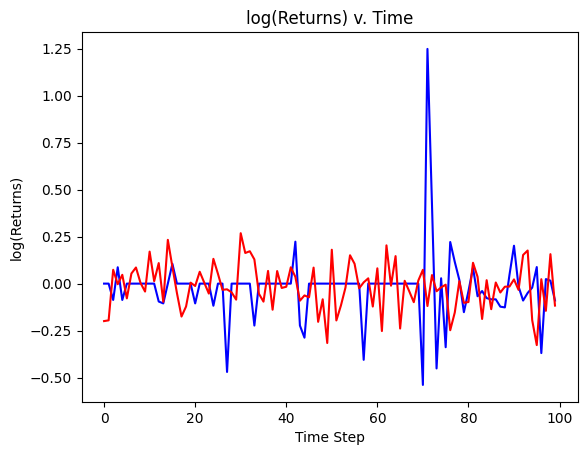

In [ ]:
remaining = len(prices) - n - 1
log = log_returns(prices[:n])
start = log[-1]
simulated = []
for i in range(remaining):
  eps = np.random.normal(scale = np.sqrt(var))
  next = mu + phi*(start - mu) + eps
  simulated.append(next)
  start = next
simulated = np.array(simulated)
print(simulated.shape)

log = log_returns(prices[:-n])
time_steps = np.arange(len(log))
plt.figure()
plt.plot(time_steps, log, color='blue')
plt.plot(time_steps, simulated, color='red')
plt.xlabel("Time Step")
plt.ylabel("log(Returns)")
plt.title("log(Returns) v. Time")
plt.show()

Note the value of $\phi$ for AAPL vs that of DVLT. What is the difference between the two? What does this imply about the behavior of the returns? (That is, if you have a positive log-return on one step, what can you say about the next time step? And vice versa.) (*Hint*: It might help to note that $X_t \approx \phi^t X_0$.)

ANSWER HERE

Note the variance values $\sigma_{\varepsilon}^2$ between the two stocks. What can you say about the two variances? What does this imply about the volatility in the returns of the two stocks?

ANSWER HERE

### Simulating Prices ###

We can use the fact that if $X_t$ is the log-return at time $t$ and $P_t$ is the closing price at time $t$, then

$$X_t = \log\left(\frac{P_t}{P_{t-1}}\right)$$

to obtain $P_t = P_{t-1}e^{X_t}$.

In [14]:
def convert_to_prices(initial_price: float, log_returns: np.ndarray) -> np.ndarray:
  intermediate = np.cumsum(log_returns)
  exp_log_returns = np.exp(intermediate)
  prices = initial_price * exp_log_returns
  prices = np.concatenate([[initial_price], prices])
  return prices

In [15]:
ticker = "AAPL"
data = yf.download(ticker, start="2024-01-01", end="2025-12-31", auto_adjust=False)
prices = data["Close"].to_numpy().squeeze()
mu, phi, var = ar_1(prices)




[*********************100%***********************]  1 of 1 completed

(500,)
(501,)
(501,)


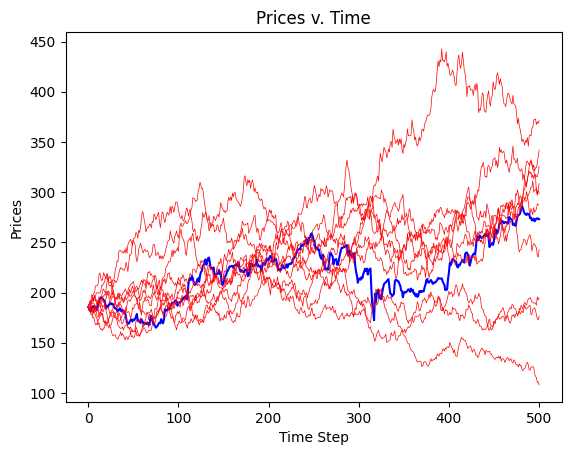

In [40]:
start = np.log(prices[1] / prices[0])
plt.figure()
time_steps = np.arange(len(prices))
plt.plot(time_steps, prices, color='blue', label='True')
plt.xlabel("Time Step")
plt.ylabel("Prices")
plt.title("Prices v. Time")

for j in range(10):
  simulated = []
  for i in range(len(prices)-1):
    eps = np.random.normal(scale = np.sqrt(var))
    next = mu + phi*(start - mu) + eps
    simulated.append(next)
    start = next
  simulated = np.array(simulated)

  simulated_prices = convert_to_prices(prices[0], simulated)

  plt.plot(time_steps, simulated_prices, color='red', linewidth=0.5, label='Simulated')
plt.show()